<a href="https://colab.research.google.com/github/ganeshmukhiya/Topic-Modeling-NMF/blob/main/comparative_model_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


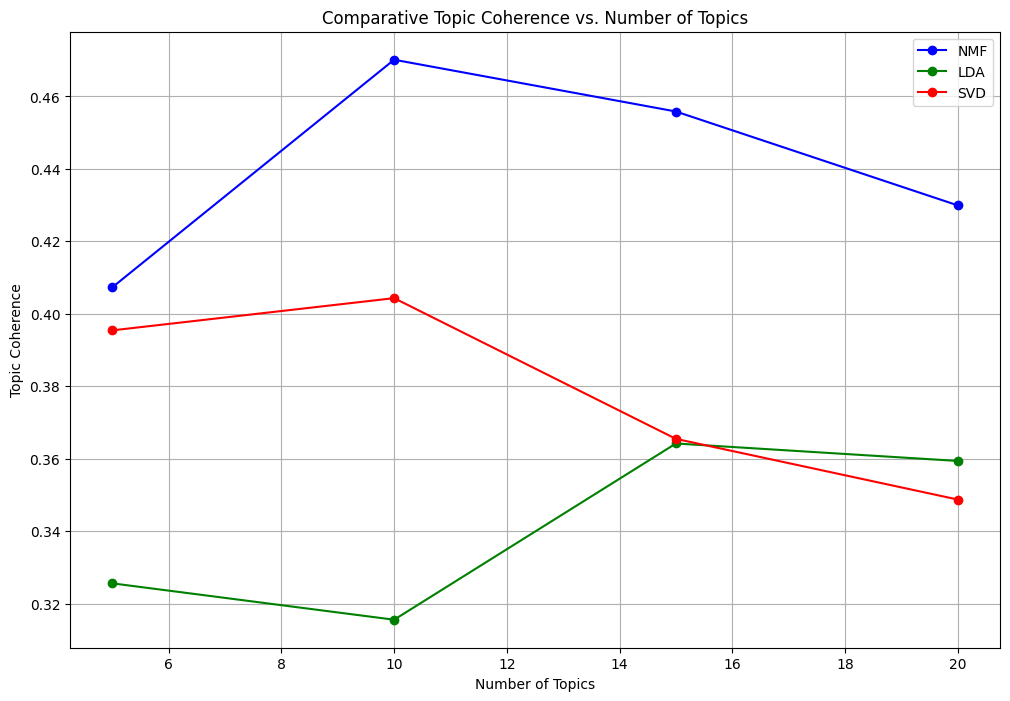

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')

# Load and preprocess data
newsgroups_train = fetch_20newsgroups(subset='train')
data = newsgroups_train.data
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = vectorizer.fit_transform(data)

# Get topics from models
def get_topics(model, vectorizer, num_words=10):
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words-1:-1]]
        topics.append(top_words)
    return topics

# Calculate coherence score
def calculate_coherence(topics, data):
    stop_words = set(stopwords.words('english'))
    texts = [[word for word in doc.split() if word not in stop_words] for doc in data]
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Range of number of topics
topics_range = [5, 10, 15, 20]
coherence_scores_nmf = []
coherence_scores_lda = []
coherence_scores_svd = []

# Evaluate NMF
for n_topics in topics_range:
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_model.fit(X)
    topics = get_topics(nmf_model, vectorizer)
    coherence_scores_nmf.append(calculate_coherence(topics, data))

# Evaluate LDA
for n_topics in topics_range:
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(X)
    topics = get_topics(lda_model, vectorizer)
    coherence_scores_lda.append(calculate_coherence(topics, data))

# Evaluate SVD (Truncated SVD for dimensionality reduction; does not provide topics directly)
for n_topics in topics_range:
    svd_model = TruncatedSVD(n_components=n_topics, random_state=42)
    svd_model.fit(X)
    topics = get_topics(svd_model, vectorizer) # Use the same method for topics extraction
    coherence_scores_svd.append(calculate_coherence(topics, data))

# Plot Topic Coherence vs. Number of Topics
plt.figure(figsize=(12, 8))
plt.plot(topics_range, coherence_scores_nmf, marker='o', linestyle='-', label='NMF', color='blue')
plt.plot(topics_range, coherence_scores_lda, marker='o', linestyle='-', label='LDA', color='green')
plt.plot(topics_range, coherence_scores_svd, marker='o', linestyle='-', label='SVD', color='red')
plt.xlabel('Number of Topics')
plt.ylabel('Topic Coherence')
plt.title('Comparative Topic Coherence vs. Number of Topics')
plt.legend()
plt.grid(True)
plt.show()
